<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from scipy import stats

# Data Cleansing [coursera]
In some process models Data Cleansing is a separate task, it is closely tied to Feature Creation but also draws findings from the Initial Data Exploration task. The actual data transformations are implemented in the Feature Creation asset deliverable; therefore, Data Cleansing is part of the Feature Creation task in this process model.

While tuning machine learning models, this deliverable asset is touched on a regular basis anyway because features need to be transformed to increase model performance. In such iterations, often issues with data are detected and therefore need to be corrected/addressed here as well.

The following none exhaustive list gives you some guidelines:

- Data types Are data types of columns matching their content? E.g. is age stored as integer and not as string?
- Ranges Does the value distribution of values in a column make sense? Use stats (e.g. min, max, mean, standard deviation) and visualizations (e.g. box-plot, histogram) for help
- Emptiness Are all values non-null where mandatory? E.g. client IDs
- Uniqueness Are duplicates present where undesired? E.g. client IDs
- Set memberships Are only allowed values chosen for categorical or ordinal fields? E.g. Female, Male, Unknown
- Foreign key set memberships Are only allowed values chosen as field? E.g. ZIP code
- Regular expressions Some files need to stick to a pattern expressed by a regular expression. E.g. a lower-case character followed by 6 digits
- Cross-field validation Some fields can impact validity of other fields. E.g. a male person can’t be pregnant


# Load data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv(data_path + 'init_data.csv' )
print(df.shape)

(48842, 15)


# Utile Functions

In [0]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def print_corr(df, attr, verbose = True):
  lb_make = LabelEncoder()
  target_enc = lb_make.fit_transform(df['target'])
  if df[attr].dtype == 'object':
    lb_make = LabelEncoder()
    src_enc = lb_make.fit_transform(df[attr])
    if verbose:
      print('Corr between', attr, 'and the target: ', cramers_v(src_enc, target_enc))
    return cramers_v(src_enc, target_enc)
  else:
    src_enc = df[attr]
    if verbose:
      print('Corr between', attr, 'and the target: ', stats.pointbiserialr(src_enc, target_enc)[0])
    return stats.pointbiserialr(src_enc, target_enc)[0]

def downcast_df(df):
  start_size = df.memory_usage(deep = True).sum() / 1024**2
  print('Memory usage: {:.2f} MB'.format(start_size))

  float_cols = [c for c in df if df[c].dtype == "float64"]
  int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
  df[float_cols] = df[float_cols].astype(np.float32)
  df[int_cols] = df[int_cols].astype(np.int32)
  end_size = df.memory_usage(deep = True).sum() / 1024**2
  print('New Memory usage: {:.2f} MB'.format(end_size))
  return df

# Remove Duplicated rows

In [5]:
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 29


We should delete duplicated rows because they don't add new information

In [6]:
df = df.drop_duplicates(keep = 'first')
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 0


# Clean data

## Remove extra characters and spaces

In [7]:
df['target'] = df['target'].str.replace('.', '')
df['target'] = df['target'].str.strip()
df['target'].value_counts()

<=50K    37128
>50K     11685
Name: target, dtype: int64

In [0]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()
        df[col] = df[col].str.lower()

## Cross-field validation
- a male can not be a wife
- a female can't be a husband
- a never married, divorced or widowed can't be husband or wife
- a separated person can't be wife or husband in the houshold

In [0]:
df.loc[(df['sex'] == 'female') & (df['relationship'] == 'husband'), 'relationship'] = 'wife'

In [0]:
df.loc[(df['sex'] == 'male') & (df['relationship'] == 'wife'), 'relationship'] = 'husband'

In [11]:
len(df[(df['marital_status'].isin(['never-married', 'divorced', 'widowed'])) & (df['relationship'].isin(['husband','wife']))])

0

In [12]:
len(df[(df['marital_status'].isin(['married-spouse-absent'])) & (df['relationship'].isin(['husband', 'wife']))])

0

# Feature Engineering [coursera]
Feature Creation and Feature Engineering is one of the most important tasks in machine learning since it hugely impacts model performance. This also holds for deep learning, although to a lesser extent. Features can be changed or new features can be created from existing ones

The following none exhaustive list gives you some guidelines for feature transformation:
- Imputing Some algorithms are very sensitive to missing values. Therefore, imputing allows for filling of empty fields based on its value distribution
- Imputed time-series quantization Time series often contain streams with measurements at different timestamps. Therefore, it is beneficial to quantize measurements to a common “heart beat” and impute the corresponding values. This can be done by sampling from the source time series distributions on the respective quantized time steps
- Scaling / Normalizing / Centering Some algorithms are very sensitive differences in value ranges for individual fields. Therefore, it is best practice to center data around zero and scale values to a standard deviation of one
- Filtering Sometimes imputing values doesn’t perform well, therefore deletion of low quality records is a better strategy
- Discretizing Continuous fields might confuse the model, e.g. a discrete set of age ranges sometimes performs better than continuous values, especially on smaller amounts of data and with simpler models


The following none exhaustive list gives you some guidelines for feature creation:
- One-hot-encoding Categorical integer features should be transformed into “one-hot” vectors. In relational terms this results in addition of additional columns – one columns for each distinct category
- Time-to-Frequency transformation Time-series (and sometimes also sequence data) is recorded in the time domain but can easily transformed into the frequency domain e.g. using FFT (Fast Fourier Transformation)
- Month-From-Date Creating an additional feature containing the month independent from data captures seasonal aspects. Sometimes further discretization in to quarters helps as well
- Aggregate-on-Target Simply aggregating fields the target variable (or even other fields) can improve performance, e.g. count number of data points per ZIP code or take the median of all values by geographical region

As feature engineering is an art on itself, this list cannot be exhaustive. It’s not expected to become an expert in this topic at this point. Most of it you’ll learn by practicing data science on real projects and talk to peers which might share their secrets and tricks with you.


## Fill missing values

In [13]:
for col in df.columns:
  print('There is: ', len(df[df[col] == '?']), ' missing values in ', col)

There is:  0  missing values in  age
There is:  2799  missing values in  workclass
There is:  0  missing values in  final_weight
There is:  0  missing values in  education
There is:  0  missing values in  education_duration
There is:  0  missing values in  marital_status
There is:  2809  missing values in  occupation
There is:  0  missing values in  relationship
There is:  0  missing values in  race
There is:  0  missing values in  sex
There is:  0  missing values in  capital_gain
There is:  0  missing values in  capital_loss
There is:  0  missing values in  hours_per_week
There is:  856  missing values in  native_country
There is:  0  missing values in  target


/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [14]:
for col in df.columns:
    df.loc[df[col] == '?', col] = 'other_unknown'

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Add missing values feature
This feature indicates how missing values each row has

In [0]:
df['has_missing_values'] = 0
def detect_missing_value(row):
    for col in df.columns:
        if row[col] == 'other_unknown':
            row['has_missing_values'] += 1
    return row
df = df.apply(detect_missing_value, axis = 1)

In [16]:
df['has_missing_values'].value_counts()

0    45194
2     2753
1      820
3       46
Name: has_missing_values, dtype: int64

In [17]:
print_corr(df, 'has_missing_values')

Corr between has_missing_values and the target:  -0.07925034430439992


-0.07925034430439992

In [0]:
df = df.drop(columns = 'has_missing_values')

## drop useless features

The column education_duration is a continuous representation of the column education. So I will delete the column education


In [0]:
df = df.drop(columns = ['education'])

In [20]:
print_corr(df, 'final_weight')

Corr between final_weight and the target:  -0.00637619990497741


-0.00637619990497741

There is no correlation between final_weight and the target, so I will drop it

In [0]:
df = df.drop(columns = 'final_weight')

## Combine categorical levels

### workclass

- federal-gov, local_gov, state_gov -> government
- private -> private
- self-emp-inc, self-emp-not-inc -> self-employed
- never-worked, without-pay -> unemployed
- ? -> other

In [0]:
df['com_workclass'] = df['workclass']
df.loc[df['com_workclass'].isin(['state-gov', 'federal-gov', 'local-gov']), 'com_workclass'] = 'government'
df.loc[df['com_workclass'].isin(['self-emp-inc', 'self-emp-not-inc']), 'com_workclass'] = 'self-employed'
df.loc[df['com_workclass'].isin(['without-pay', 'never-worked']), 'com_workclass'] = 'unemployed'

In [23]:
print_corr(df, 'workclass')
print_corr(df, 'com_workclass')

Corr between workclass and the target:  0.1812067476853715
Corr between com_workclass and the target:  0.14614764101506048


0.14614764101506048

let us drop the new feature com_workclass

In [0]:
df = df.drop(columns = 'com_workclass')

### marital_status

 - “never-married,” “widowed,” and “divorced” ->  “single”
 - “married-civ-spouse”, “separated”, “married-af-spouse” and “married-spouse-absent” -> “married”

In [0]:
df['com_marital_status'] = df['marital_status']
df.loc[df['com_marital_status'].isin(['never-married' 'widowed', 'divorced']), 'com_marital_status'] = 'single'
df.loc[df['com_marital_status'].isin(
    ['married-civ-spouse' 'separated', 'married-af-spouse', 'married-spouse-absent']), 'com_marital_status'] = 'single'

In [26]:
print_corr(df, 'marital_status')
print_corr(df, 'com_marital_status')

Corr between marital_status and the target:  0.4481092378164384
Corr between com_marital_status and the target:  0.44779218790941633


0.44779218790941633

In [0]:
df = df.drop(columns = 'com_marital_status')

### native_country

In [0]:
north_america = ['united-states', 'cuba', 'jamaica', 'mexico', 'canada',
'puerto-rico', 'honduras',  'haiti', 'dominican-republic', 
'el-salvador',  'guatemala',  'outlying-us(guam-usvi-etc)',  
'trinadad&tobago', 'nicaragua',  
]

other = ['other_unknown', 'south']

asia = ['india', 'china', 'japan', 'vietnam', 'hong', 'iran', 'philippines', 'cambodia', 'thailand', 'laos', 'taiwan']

europe = ['england', 'germany', 'italy', 'poland', 'ireland', 'hungary',
'holand-netherlands', 'scotland', 'yugoslavia', 'greece', 'france', 'portugal',]

south_america = ['peru',  'columbia',  'ecuador', ]

In [0]:
df.loc[df['native_country'].isin(asia), 'com_native_country'] = 'aisa'
df.loc[df['native_country'].isin(europe), 'com_native_country'] = 'europe'
df.loc[df['native_country'].isin(north_america), 'com_native_country'] = 'north_america'
df.loc[df['native_country'].isin(south_america), 'com_native_country'] = 'south_america'
df.loc[df['native_country'].isin(other), 'com_native_country'] = 'other'

In [30]:
print_corr(df, 'native_country')
print_corr(df, 'com_native_country')

Corr between native_country and the target:  0.09159272240334079
Corr between com_native_country and the target:  0.033447597767781924


0.033447597767781924

In [0]:
df = df.drop(columns = ['native_country', 'com_native_country'])

## Generate polynomial and interaction features

In [0]:
cont_featrues = ['age', 'education_duration', 'hours_per_week', 'capital_gain', 'capital_loss' ]
pl = PolynomialFeatures(2, include_bias = False)
X_temp = pl.fit_transform(df[cont_featrues])
poly_columns_names = pl.get_feature_names(cont_featrues)
df_temp = pd.DataFrame(data = X_temp, columns = poly_columns_names)
df = df.merge(df_temp, on = cont_featrues)

###  Crossing feature: age & hours_per_work

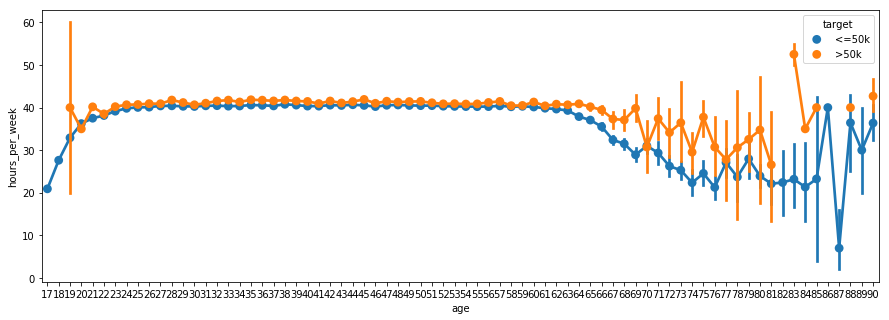

In [33]:
fig = plt.figure(figsize=(15, 5))
g = sns.pointplot(x = 'age', y = 'hours_per_week', hue = 'target', data = df)
plt.show()

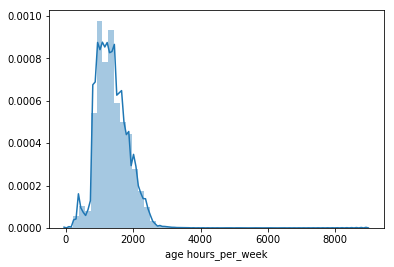

In [34]:
sns.distplot(df['age hours_per_week'])
plt.show()

## Bin continuous features

In [0]:
if 'poly_columns_names' in poly_columns_names: poly_columns_names.remove('education_duration')

In [36]:
binned_features = []
for col in poly_columns_names:
  print('Binning ', col,)
  upper_bound = df[col].max()
  quantity =  30
  hist, bin_edges = np.histogram(df[col], bins = quantity, density = True)
  bin_edges = np.append(bin_edges, upper_bound + 1)
  labels = [col + '_bin_{0}'.format(itr + 1) for itr in np.arange(len(bin_edges) - 1)]
  df[col + '_bin'] = pd.cut(df[col], bins = bin_edges, labels = labels, right = False)
  print_corr(df, col)
  df[col + '_bin'] = df[col + '_bin'].astype('object')
  print_corr(df, col + '_bin')
  binned_features.append(col + '_bin')
  print('***********************************************')

Binning  age
Corr between age and the target:  0.2586678398806067
Corr between age_bin and the target:  0.27965419867948293
***********************************************
Binning  education_duration
Corr between education_duration and the target:  0.18402696282613767
Corr between education_duration_bin and the target:  0.2000324995136853
***********************************************
Binning  hours_per_week
Corr between hours_per_week and the target:  0.13046362466401312
Corr between hours_per_week_bin and the target:  0.15441816367538416
***********************************************
Binning  capital_gain
Corr between capital_gain and the target:  0.052352066031751514
Corr between capital_gain_bin and the target:  0.0852909771924117
***********************************************
Binning  capital_loss
Corr between capital_loss and the target:  0.041064485479673105
Corr between capital_loss_bin and the target:  0.051003350569388935
***********************************************
Bin

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Corr between capital_gain capital_loss and the target:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Corr between capital_gain capital_loss_bin and the target:  nan
***********************************************
Binning  capital_loss^2
Corr between capital_loss^2 and the target:  0.040555170605750125
Corr between capital_loss^2_bin and the target:  0.05166665250796031
***********************************************


### Delete weak correlated features

In [37]:
for col in poly_columns_names:
  corr = print_corr(df, col, verbose = False)
  if corr < 0.1 or corr == np.nan:
    df = df.drop(columns = col)
for col in binned_features:
  corr = print_corr(df, col, verbose = False)
  if corr < 0.1 or corr == np.nan:
    df = df.drop(columns = col)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


### age

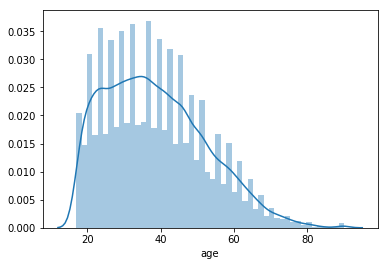

In [0]:
sns.distplot(df['age'])
plt.show()

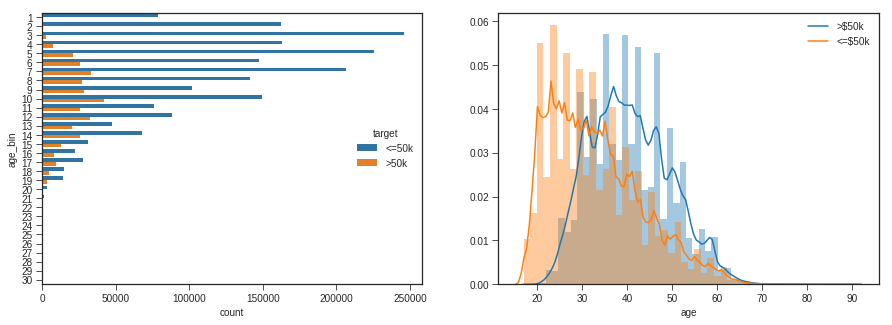

In [0]:
bin_number = 30
df['age_bin'] = pd.cut(df['age'], bin_number, labels = [str(i + 1) for i in np.arange(bin_number)])
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age_bin", hue = 'target', data=df)
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['age'], kde_kws={"label": ">$50k"})
sns.distplot(df[df['target'] == '<=50k']['age'], kde_kws={"label": "<=$50k"})

In [0]:
print_corr(df, 'age')
df['age_bin'] = df['age_bin'].astype('object')
print_corr(df, 'age_bin')

Corr between age and the target:  PointbiserialrResult(correlation=0.2586678398806067, pvalue=0.0)
Corr between age_bin and the target:  0.27965419867948293


In [0]:
df['age_bin'].isnull().sum()

94

### hours_per_week

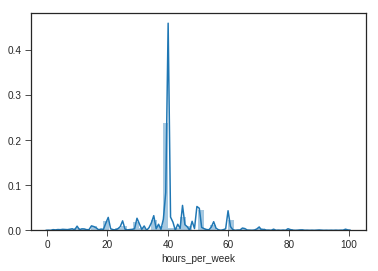

In [0]:
sns.distplot(df['hours_per_week'])
plt.show()

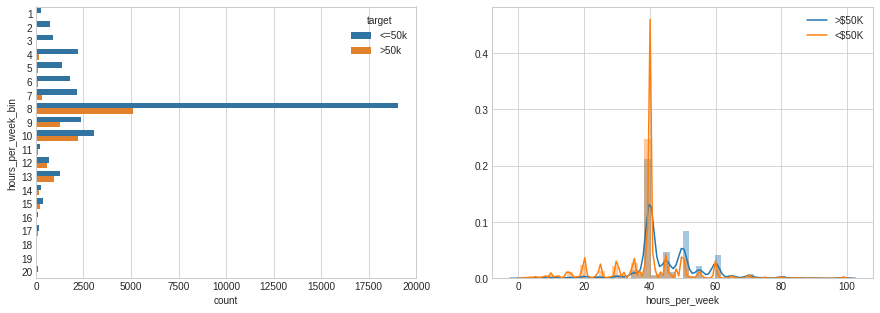

In [0]:
bin_number = 20
df['hours_per_week_bin'] = pd.cut(df['hours_per_week'], bin_number, labels = [str(i + 1) for i in np.arange(bin_number)])
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y = "hours_per_week_bin", hue = 'target', data = df);
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['hours_per_week'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['hours_per_week'], kde_kws={"label": "<$50K"})
plt.show()

In [0]:
print_corr(df, 'hours_per_week')
df['hours_per_week_bin'] = df['hours_per_week_bin'].astype('object')
print_corr(df, 'hours_per_week_bin')

Corr between hours_per_week and the target:  PointbiserialrResult(correlation=0.2276494944005854, pvalue=0.0)
Corr between hours_per_week_bin and the target:  0.2749110639535535


### capital_gain

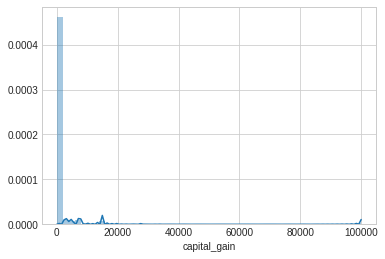

In [0]:
sns.distplot(df['capital_gain'])
plt.show()

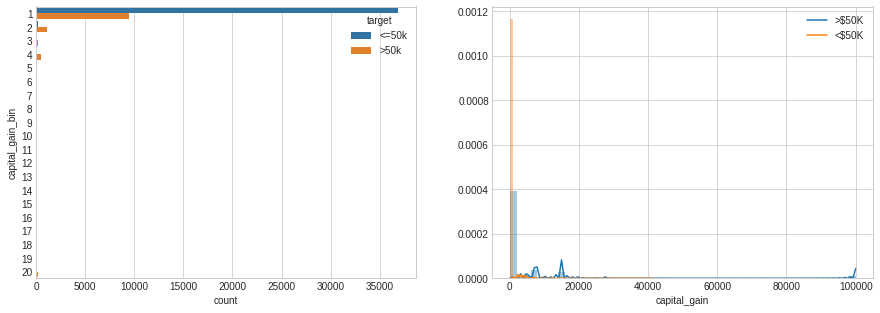

In [0]:
bin_number = 20
df['capital_gain_bin'] = pd.cut(df['capital_gain'], bin_number, labels = [str(i + 1) for i in np.arange(bin_number)])
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y = "capital_gain_bin", hue = 'target', data = df);
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['capital_gain'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['capital_gain'], kde_kws={"label": "<$50K"})
plt.show()

In [0]:
print_corr(df, 'capital_gain')
df['capital_gain_bin'] = df['capital_gain_bin'].astype('object')
print_corr(df, 'capital_gain_bin')

Corr between capital_gain and the target:  PointbiserialrResult(correlation=0.22301398145686202, pvalue=0.0)
Corr between capital_gain_bin and the target:  0.3599203569218101


### capital_loss

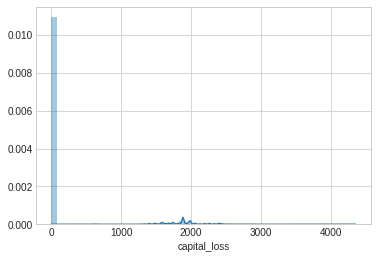

In [0]:
sns.distplot(df['capital_loss'])
plt.show()

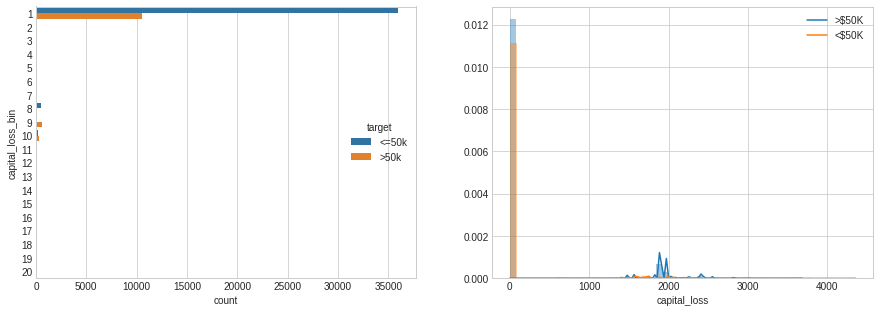

In [0]:
bin_number = 20
df['capital_loss_bin'] = pd.cut(df['capital_loss'], bin_number, labels = [str(i + 1) for i in np.arange(bin_number)])
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)
sns.countplot(y = "capital_loss_bin", hue = 'target', data = df);
plt.subplot(1, 2, 2)
sns.distplot(df[df['target'] == '>50k']['capital_loss'], kde_kws={"label": ">$50K"})
sns.distplot(df[df['target'] == '<=50k']['capital_loss'], kde_kws={"label": "<$50K"})
plt.show()

In [0]:
print_corr(df, 'capital_loss')
df['capital_loss_bin'] = df['capital_loss_bin'].astype('object')
print_corr(df, 'capital_loss_bin')

Corr between capital_loss and the target:  PointbiserialrResult(correlation=0.14752749360857575, pvalue=1.4347540359310811e-235)
Corr between capital_loss_bin and the target:  0.2110700696509502


# Encode target

In [0]:
df.loc[df['target'] == '<=50k', 'target'] = 0
df.loc[df['target'] == '>50k', 'target'] = 1

# Features classification

In [0]:
target = ['target']
categorical_features = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', ]

binned_features = [col for col in  df.columns if '_bin' in col]
all_cat_features = binned_features + categorical_features

continuous_features = list(set(df.columns).difference(set(all_cat_features + target)))

In [63]:
print('Data features: ', len(df.columns) - 1)
print('Continuous features: ', len(continuous_features))
print('Binned features: ', len(binned_features))
print('Categorical features: ', len(categorical_features))

Data features:  26
Continuous features:  10
Binned features:  10
Categorical features:  6


# Scale continuous features

In [0]:
min_max_scaler = MinMaxScaler()
df[continuous_features] = min_max_scaler.fit_transform(df[continuous_features])

# Define dataframes for different encodings

In [75]:
# dataframe that contains: continuous and label encoded categorical features
cont_cat_lb = df.copy()
cont_cat_lb = cont_cat_lb.drop(columns = binned_features)

# dataframe that contains: continuous and one-hot encoded categorical features
cont_cat_oh = df.copy()
cont_cat_oh = cont_cat_oh.drop(columns = binned_features)

# dataframe that contains: label encoded binned and label encoded categorical features
bin_lb_cat_lb = df.copy()
bin_lb_cat_lb = bin_lb_cat_lb.drop(columns = continuous_features)

# dataframe that contains: one-hot encoded binned and one-hot encoded categorical features
bin_oh_cat_oh = df.copy()
bin_oh_cat_oh = bin_oh_cat_oh.drop(columns = continuous_features)

print('cont_cat_lb: ', len(cont_cat_lb.columns))
print('cont_cat_oh: ', len(cont_cat_oh.columns))
print('bin_lb_cat_lb: ', len(bin_lb_cat_lb.columns))
print('bin_oh_cat_oh: ', len(bin_oh_cat_oh.columns))

cont_cat_lb:  17
cont_cat_oh:  17
bin_lb_cat_lb:  17
bin_oh_cat_oh:  17


# Encode categorical features

## Label_encoding

In [0]:
for col in categorical_features:
  lb_enc = LabelEncoder()
  cont_cat_lb[col] = lb_enc.fit_transform(cont_cat_lb[col])
for col in categorical_features + binned_features:
  lb_enc = LabelEncoder()
  bin_lb_cat_lb[col] = lb_enc.fit_transform(bin_lb_cat_lb[col])

In [77]:
print('cont_cat_lb: ', len(cont_cat_lb.columns))
print('bin_lb_cat_lb: ', len(bin_lb_cat_lb.columns))

cont_cat_lb:  17
bin_lb_cat_lb:  17


## One hot encoding

In [0]:
cont_cat_oh = pd.get_dummies(cont_cat_oh, columns = categorical_features)
bin_oh_cat_oh = pd.get_dummies(bin_oh_cat_oh, columns = categorical_features + binned_features)

In [79]:
print('cont_cat_oh: ', len(cont_cat_oh.columns))
print('bin_oh_cat_oh: ', len(bin_oh_cat_oh.columns))

cont_cat_oh:  55
bin_oh_cat_oh:  286


# Save data

In [80]:
cont_cat_lb = downcast_df(cont_cat_lb)

Memory usage: 323.60 MB
New Memory usage: 170.79 MB


In [81]:
cont_cat_oh = downcast_df(cont_cat_oh)

Memory usage: 314.61 MB
New Memory usage: 215.73 MB


In [82]:
bin_lb_cat_lb = downcast_df(bin_lb_cat_lb)

Memory usage: 323.60 MB
New Memory usage: 170.79 MB


In [83]:
bin_oh_cat_oh = downcast_df(bin_oh_cat_oh)

Memory usage: 676.41 MB
New Memory usage: 667.42 MB


In [0]:
cont_cat_lb.to_csv(data_path + 'data_cont_cat_lb.csv', index = False)
cont_cat_oh.to_csv(data_path + 'data_cont_cat_oh.csv', index = False)
bin_lb_cat_lb.to_csv(data_path + 'data_bin_lb_cat_lb.csv', index = False)
bin_oh_cat_oh.to_csv(data_path + 'data_bin_oh_cat_oh.csv', index = False)

In [0]:
cont_cat_lb.to_pickle(data_path + 'data_cont_cat_lb.pkl')
cont_cat_oh.to_pickle(data_path + 'data_cont_cat_oh.pkl')
bin_lb_cat_lb.to_pickle(data_path + 'data_bin_lb_cat_lb.pkl')
bin_oh_cat_oh.to_pickle(data_path + 'data_bin_oh_cat_oh.pkl')

In [0]:
print('Finished !')